In [ ]:
# import modules
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time

import torch
import torch.nn as nn



In [ ]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU instead.")

Using GPU: Tesla T4


In [ ]:

#Data is directly downloaded from Yahoo Finance
# initialize parameters
start_date = datetime(2011, 11, 1)
end_date = datetime(2023, 11, 1)
stock_ticker= 'GS'
# get the data
data = yf.download(stock_ticker, start = start_date,
				end = end_date)


[*********************100%%**********************]  1 of 1 completed


In [ ]:
data['Date']=data.index
data.head()

,Open,High,Low,Close,Adj Close,Volume,Date
Date,,,,,,,
2011-11-01,103.489998,107.099998,102.709999,103.540001,83.092804,10225400,2011-11-01
2011-11-02,106.449997,107.250000,104.750000,106.129997,85.171295,5602800,2011-11-02
2011-11-03,108.029999,108.709999,102.089996,107.680000,86.415230,8295100,2011-11-03
2011-11-04,106.330002,106.570000,103.809998,105.040001,84.296577,6074600,2011-11-04
2011-11-07,104.949997,106.150002,103.750000,105.570000,84.721909,4696900,2011-11-07


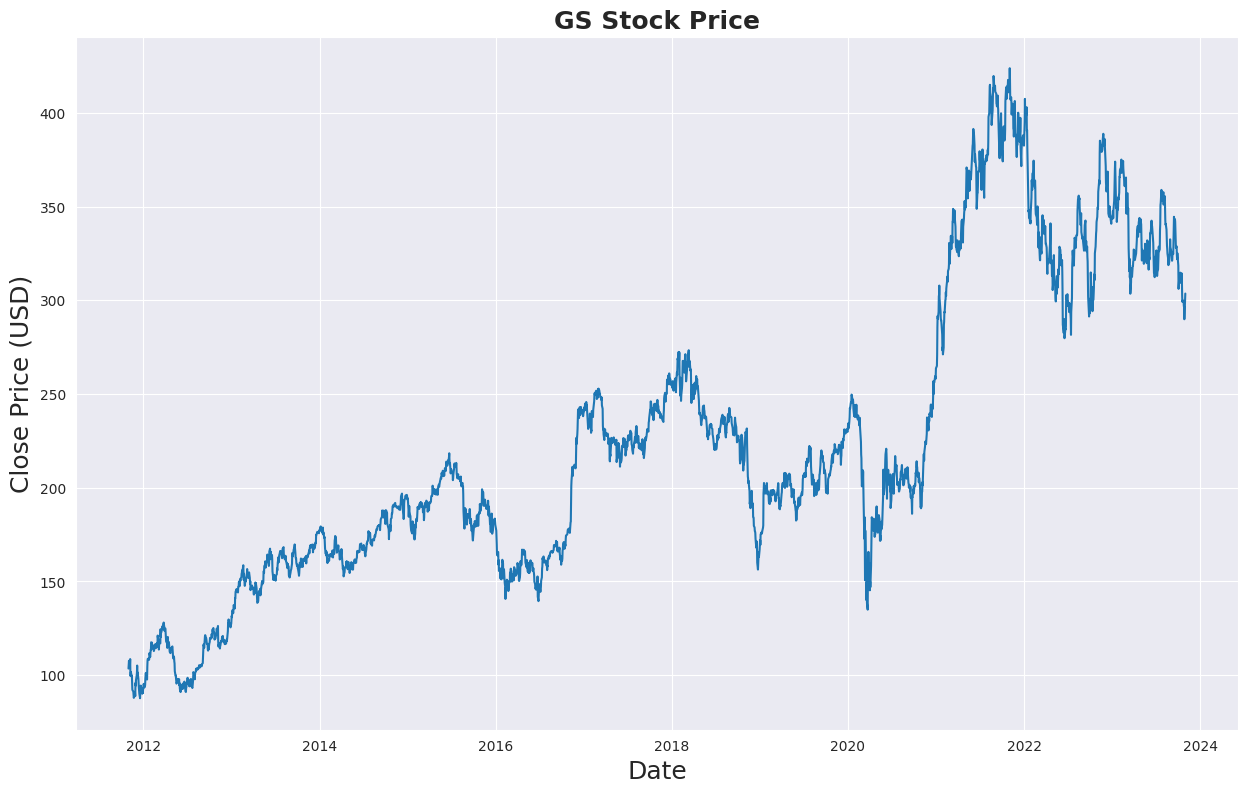

In [ ]:
#Plotting Stock Price
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.title(stock_ticker + " Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()


In [ ]:
price = data[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3019 entries, 2011-11-01 to 2023-10-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3019 non-null   float64
dtypes: float64(1)
memory usage: 47.2 KB


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

<ipython-input-21-77e3f41ac3d3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


In [ ]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []

    # create a list of time series of window size lookback
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data);
    # The last 20% of the data as test set
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    #assign the first lookback -1 time steps as input x and the last time step as target y
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1,:]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]

Choosing a lookback period of 30 days for the Stacked LSTM model is strategic for several reasons, particularly in the context of stock price prediction:

Monthly Trends: A 30-day period captures the short-term market dynamics, including monthly trends, which are often considered by traders. This timeframe is reflective of a typical business month, accounting for cyclical patterns that monthly financial activities and reports might influence.

Balancing Granularity and Computational Efficiency: A 30-day lookback strikes a balance between providing enough data points for the model to learn the temporal dependencies and being computationally efficient. Too short a lookback period might not provide sufficient information for the model to understand the trends, while too long a lookback might introduce noise and complicate the model unnecessarily.

Relevance to Financial Indicators: Many financial indicators and moving averages are calculated on a monthly basis. A 30-day lookback aligns the LSTM inputs with these indicators, allowing the model to learn from data that resonates with traditional financial analysis.

Seasonality and News Cycle: The 30-day window is long enough to cover the effects of typical seasonality in market behavior and the average news cycle, which can affect stock prices.




In [ ]:
lookback = 30 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

x_train.shape =  (2391, 29, 1)
y_train.shape =  (2391, 1)
x_test.shape =  (598, 29, 1)
y_test.shape =  (598, 1)


In [ ]:
class StackedLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_rate):
        super(StackedLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Stacked LSTM layers with dropout
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate)

        # Fully connected layer
        self.fc =nn.Sequential(nn.Dropout(dropout_rate), nn.Linear(hidden_dim, output_dim))

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])  # Take the output of the last time step
        return out


In [ ]:
def train(model, x_train, y_train, num_epochs,optimizer,device):
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    train_losses = np.zeros(num_epochs)
    start_time = time.time()
    for t in range(num_epochs):
      y_train_pred = model(x_train)
      loss = criterion(y_train_pred, y_train)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      print("Epoch ", t, "MSE: ", loss.item())
      train_losses[t] = loss.item()

    training_time = time.time()-start_time
    print("Training time: {}".format(training_time))
    return y_train_pred, train_losses,training_time

In [ ]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import torch.optim as optim
def objective(params):
    # Create a new StackedLSTM model with hyperparameters from Hyperopt
    model = StackedLSTM(
        input_dim=1,
        hidden_dim=int(params['hidden_dim']),
        num_layers=int(params['num_layers']),
        output_dim=1,
        dropout_rate=params['dropout']
    ).to(device)


    # Choose optimizer
    if params['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'],weight_decay=params['weight_decay'])
    elif params['optimizer'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=0.9,weight_decay=params['weight_decay'])
    elif params['optimizer'] == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=params['learning_rate'],weight_decay=params['weight_decay'])

    criterion = nn.MSELoss()

    # Train the model using your existing training function
    _, train_losses, _ = train(model, x_train, y_train, num_epochs=100,optimizer=optimizer,device=device)

    loss_to_minimize = train_losses[-1]
    return {'loss': loss_to_minimize, 'status': STATUS_OK}


In [ ]:
space = {
    'hidden_dim': hp.choice('hidden_dim', [32, 64, 128, 256]),
    'num_layers': hp.choice('num_layers', [1, 2, 3]),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
    'dropout': hp.uniform('dropout', 0, 0.5),
    'optimizer': hp.choice('optimizer', ['adam', 'sgd', 'rmsprop']),
    'weight_decay': hp.loguniform('weight_decay', np.log(1e-10), np.log(1e-2))
}


In [ ]:
criterion = nn.MSELoss()

In [ ]:
# Run the optimization
best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

print("Best Hyperparameters:", best_params)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1881658346981947 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



Epoch 
0
MSE: 
0.167790025472641
Epoch 
1
MSE: 
0.13844069838523865
Epoch 
2
MSE: 
0.11469615250825882
Epoch 
3
MSE: 
0.09768994897603989
Epoch 
4
MSE: 
0.08850262314081192
Epoch 
5
MSE: 
0.08578310161828995
Epoch 
6
MSE: 
0.08838730305433273
Epoch 
7
MSE: 
0.08660505712032318
Epoch 
8
MSE: 
0.0826115533709526
Epoch 
9
MSE: 
0.07605607807636261
Epoch 
10
MSE: 
0.07059426605701447
Epoch 
11
MSE: 
0.06512702256441116
Epoch 
12
MSE: 
0.06132978945970535
Epoch 
13
MSE: 
0.05821441859006882
Epoch 
14
MSE: 
0.05598313733935356
Epoch 
15
MSE: 
0.05197332054376602
Epoch 
16
MSE: 
0.04644812270998955
Epoch 
17
MSE: 
0.039022188633680344
Epoch 
18
MSE: 
0.030744878575205803
Epoch 
19
MSE: 
0.023967089131474495
Epoch 
20
MSE: 
0.02122146636247635
Epoch 
21
MSE: 
0.018108975142240524
Epoch 
22
MSE: 
0.010247889906167984
Epoch 
23
MSE: 
0.00808707345277071
Epoch 
24
MSE: 
0.014345022849738598
Epoch 
25
MSE: 
0.015108948573470116
Epoch 
26
MSE: 
0.010934951715171337
Epoch 
27
MSE: 
0.008246055804193

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.45579098305318777 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



MSE: 
0.26371482014656067
Epoch 
3
MSE: 
0.2472430318593979
Epoch 
4
MSE: 
0.23143517971038818
Epoch 
5
MSE: 
0.21661444008350372
Epoch 
6
MSE: 
0.20175249874591827
Epoch 
7
MSE: 
0.18648691475391388
Epoch 
8
MSE: 
0.17091940343379974
Epoch 
9
MSE: 
0.1554604470729828
Epoch 
10
MSE: 
0.14050832390785217
Epoch 
11
MSE: 
0.12467540055513382
Epoch 
12
MSE: 
0.10847391188144684
Epoch 
13
MSE: 
0.09366852790117264
Epoch 
14
MSE: 
0.0782824382185936
Epoch 
15
MSE: 
0.06546174734830856
Epoch 
16
MSE: 
0.06124808266758919
Epoch 
17
MSE: 
0.07030073553323746
Epoch 
18
MSE: 
0.08035887032747269
Epoch 
19
MSE: 
0.07686450332403183
Epoch 
20
MSE: 
0.06571868062019348
Epoch 
21
MSE: 
0.05779385566711426
Epoch 
22
MSE: 
0.05598746985197067
Epoch 
23
MSE: 
0.054487477988004684
Epoch 
24
MSE: 
0.05319629982113838
Epoch 
25
MSE: 
0.0547560416162014
Epoch 
26
MSE: 
0.054960090667009354
Epoch 
27
MSE: 
0.05571924149990082
Epoch 
28
MSE: 
0.05399633198976517
Epoch 
29
MSE: 
0.05377335101366043
Epoch 
30
M

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.15346673590219323 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



Epoch 
6
MSE: 
0.04063889756798744
Epoch 
7
MSE: 
0.03211067616939545
Epoch 
8
MSE: 
0.026080625131726265
Epoch 
9
MSE: 
0.04039083793759346
Epoch 
10
MSE: 
0.042654167860746384
Epoch 
11
MSE: 
0.05314413458108902
Epoch 
12
MSE: 
0.03234659880399704
Epoch 
13
MSE: 
0.02120424434542656
Epoch 
14
MSE: 
0.01813570223748684
Epoch 
15
MSE: 
0.016661763191223145
Epoch 
16
MSE: 
0.015421966090798378
Epoch 
17
MSE: 
0.014081772416830063
Epoch 
18
MSE: 
0.013249445706605911
Epoch 
19
MSE: 
0.012518711388111115
Epoch 
20
MSE: 
0.01155034638941288
Epoch 
21
MSE: 
0.011188449338078499
Epoch 
22
MSE: 
0.010666622780263424
Epoch 
23
MSE: 
0.00983803253620863
Epoch 
24
MSE: 
0.009457065723836422
Epoch 
25
MSE: 
0.008986120112240314
Epoch 
26
MSE: 
0.00815245695412159
Epoch 
27
MSE: 
0.007692770101130009
Epoch 
28
MSE: 
0.00709731038659811
Epoch 
29
MSE: 
0.00689541082829237
Epoch 
30
MSE: 
0.005954395979642868
Epoch 
31
MSE: 
0.00575533090159297
Epoch 
32
MSE: 
0.0052388859912753105
Epoch 
33
MSE: 
0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.46384766693716395 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



MSE: 
0.20993323624134064
Epoch 
3
MSE: 
0.2082100510597229
Epoch 
4
MSE: 
0.20657454431056976
Epoch 
5
MSE: 
0.2057037502527237
Epoch 
6
MSE: 
0.20434224605560303
Epoch 
7
MSE: 
0.20128029584884644
Epoch 
8
MSE: 
0.19910860061645508
Epoch 
9
MSE: 
0.19655531644821167
Epoch 
10
MSE: 
0.19353283941745758
Epoch 
11
MSE: 
0.19094546139240265
Epoch 
12
MSE: 
0.1881805658340454
Epoch 
13
MSE: 
0.18534444272518158
Epoch 
14
MSE: 
0.18283239006996155
Epoch 
15
MSE: 
0.1797322779893875
Epoch 
16
MSE: 
0.1764502227306366
Epoch 
17
MSE: 
0.1736314445734024
Epoch 
18
MSE: 
0.1711505800485611
Epoch 
19
MSE: 
0.16777464747428894
Epoch 
20
MSE: 
0.1655551791191101
Epoch 
21
MSE: 
0.16317328810691833
Epoch 
22
MSE: 
0.1601940393447876
Epoch 
23
MSE: 
0.1574099063873291
Epoch 
24
MSE: 
0.15440884232521057
Epoch 
25
MSE: 
0.15183882415294647
Epoch 
26
MSE: 
0.15017908811569214
Epoch 
27
MSE: 
0.14727471768856049
Epoch 
28
MSE: 
0.14451149106025696
Epoch 
29
MSE: 
0.14230534434318542
Epoch 
30
MSE: 
0.1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3273160309704931 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



7
MSE: 
0.2149769812822342
Epoch 
8
MSE: 
0.21286273002624512
Epoch 
9
MSE: 
0.21269634366035461
Epoch 
10
MSE: 
0.2112967073917389
Epoch 
11
MSE: 
0.20895561575889587
Epoch 
12
MSE: 
0.20771734416484833
Epoch 
13
MSE: 
0.20669503509998322
Epoch 
14
MSE: 
0.20478813350200653
Epoch 
15
MSE: 
0.20380263030529022
Epoch 
16
MSE: 
0.2023308426141739
Epoch 
17
MSE: 
0.20094841718673706
Epoch 
18
MSE: 
0.19967611134052277
Epoch 
19
MSE: 
0.19728977978229523
Epoch 
20
MSE: 
0.1967448741197586
Epoch 
21
MSE: 
0.19400887191295624
Epoch 
22
MSE: 
0.19285477697849274
Epoch 
23
MSE: 
0.19201308488845825
Epoch 
24
MSE: 
0.189828559756279
Epoch 
25
MSE: 
0.18831662833690643
Epoch 
26
MSE: 
0.1873614639043808
Epoch 
27
MSE: 
0.1847037374973297
Epoch 
28
MSE: 
0.18408896028995514
Epoch 
29
MSE: 
0.18274269998073578
Epoch 
30
MSE: 
0.18144892156124115
Epoch 
31
MSE: 
0.1797305941581726
Epoch 
32
MSE: 
0.1789657473564148
Epoch 
33
MSE: 
0.17603179812431335
Epoch 
34
MSE: 
0.17437468469142914
Epoch 
35
MS

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.16567608581516036 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



Streaming output truncated to the last 5000 lines.
0.02200818620622158
Epoch 
57
MSE: 
0.02228091098368168
Epoch 
58
MSE: 
0.022078724578022957
Epoch 
59
MSE: 
0.021029053255915642
Epoch 
60
MSE: 
0.02170923724770546
Epoch 
61
MSE: 
0.020499950274825096
Epoch 
62
MSE: 
0.021222252398729324
Epoch 
63
MSE: 
0.0209548007696867
Epoch 
64
MSE: 
0.021574852988123894
Epoch 
65
MSE: 
0.021950554102659225
Epoch 
66
MSE: 
0.02057710848748684
Epoch 
67
MSE: 
0.020548783242702484
Epoch 
68
MSE: 
0.020481761544942856
Epoch 
69
MSE: 
0.01985875889658928
Epoch 
70
MSE: 
0.01951194927096367
Epoch 
71
MSE: 
0.01966254599392414
Epoch 
72
MSE: 
0.019390849396586418
Epoch 
73
MSE: 
0.01892714947462082
Epoch 
74
MSE: 
0.019421765580773354
Epoch 
75
MSE: 
0.01875598542392254
Epoch 
76
MSE: 
0.018597425892949104
Epoch 
77
MSE: 
0.018500978127121925
Epoch 
78
MSE: 
0.017952345311641693
Epoch 
79
MSE: 
0.01739415153861046
Epoch 
80
MSE: 
0.01726607233285904
Epoch 
81
MSE: 
0.017857110127806664
Epoch 
82
MSE: 


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.26196526351806004 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



Epoch 
3
MSE: 
0.1322697103023529
Epoch 
4
MSE: 
0.0949806198477745
Epoch 
5
MSE: 
0.07018658518791199
Epoch 
6
MSE: 
0.12146292626857758
Epoch 
7
MSE: 
0.07868407666683197
Epoch 
8
MSE: 
0.06464595347642899
Epoch 
9
MSE: 
0.06569942086935043
Epoch 
10
MSE: 
0.06864393502473831
Epoch 
11
MSE: 
0.07106901705265045
Epoch 
12
MSE: 
0.07193529605865479
Epoch 
13
MSE: 
0.06970402598381042
Epoch 
14
MSE: 
0.06669092178344727
Epoch 
15
MSE: 
0.06170865148305893
Epoch 
16
MSE: 
0.05566681548953056
Epoch 
17
MSE: 
0.04859411343932152
Epoch 
18
MSE: 
0.04245695099234581
Epoch 
19
MSE: 
0.03816617652773857
Epoch 
20
MSE: 
0.03834493085741997
Epoch 
21
MSE: 
0.040963850915431976
Epoch 
22
MSE: 
0.037167955189943314
Epoch 
23
MSE: 
0.02836531400680542
Epoch 
24
MSE: 
0.023319285362958908
Epoch 
25
MSE: 
0.021994836628437042
Epoch 
26
MSE: 
0.021604150533676147
Epoch 
27
MSE: 
0.019791916012763977
Epoch 
28
MSE: 
0.01487643551081419
Epoch 
29
MSE: 
0.008973506279289722
Epoch 
30
MSE: 
0.014523707330

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.027591447798710533 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



0.2762153148651123
Epoch 
7
MSE: 
0.26402631402015686
Epoch 
8
MSE: 
0.2510306239128113
Epoch 
9
MSE: 
0.23791205883026123
Epoch 
10
MSE: 
0.224711075425148
Epoch 
11
MSE: 
0.21177759766578674
Epoch 
12
MSE: 
0.19934722781181335
Epoch 
13
MSE: 
0.18713277578353882
Epoch 
14
MSE: 
0.17575113475322723
Epoch 
15
MSE: 
0.1650916188955307
Epoch 
16
MSE: 
0.15496644377708435
Epoch 
17
MSE: 
0.14563892781734467
Epoch 
18
MSE: 
0.13723382353782654
Epoch 
19
MSE: 
0.12948112189769745
Epoch 
20
MSE: 
0.12255404144525528
Epoch 
21
MSE: 
0.11629663407802582
Epoch 
22
MSE: 
0.11103613674640656
Epoch 
23
MSE: 
0.10626740008592606
Epoch 
24
MSE: 
0.10191626846790314
Epoch 
25
MSE: 
0.09847700595855713
Epoch 
26
MSE: 
0.09525210410356522
Epoch 
27
MSE: 
0.09273592382669449
Epoch 
28
MSE: 
0.09059734642505646
Epoch 
29
MSE: 
0.08876469731330872
Epoch 
30
MSE: 
0.08741595596075058
Epoch 
31
MSE: 
0.0862334817647934
Epoch 
32
MSE: 
0.08539602160453796
Epoch 
33
MSE: 
0.08471633493900299
Epoch 
34
MSE: 
0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.28646186201194823 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



Epoch 
2
MSE: 
0.20742087066173553
Epoch 
3
MSE: 
0.19620759785175323
Epoch 
4
MSE: 
0.18482689559459686
Epoch 
5
MSE: 
0.17335617542266846
Epoch 
6
MSE: 
0.16260980069637299
Epoch 
7
MSE: 
0.15187427401542664
Epoch 
8
MSE: 
0.14092569053173065
Epoch 
9
MSE: 
0.1297808289527893
Epoch 
10
MSE: 
0.11885610222816467
Epoch 
11
MSE: 
0.10795989632606506
Epoch 
12
MSE: 
0.09668715298175812
Epoch 
13
MSE: 
0.08590961247682571
Epoch 
14
MSE: 
0.07687617838382721
Epoch 
15
MSE: 
0.07285887748003006
Epoch 
16
MSE: 
0.07816555351018906
Epoch 
17
MSE: 
0.08460088074207306
Epoch 
18
MSE: 
0.07998662441968918
Epoch 
19
MSE: 
0.07281740754842758
Epoch 
20
MSE: 
0.06764400750398636
Epoch 
21
MSE: 
0.06457691639661789
Epoch 
22
MSE: 
0.06376712769269943
Epoch 
23
MSE: 
0.06344421952962875
Epoch 
24
MSE: 
0.06342258304357529
Epoch 
25
MSE: 
0.062458332628011703
Epoch 
26
MSE: 
0.06113867461681366
Epoch 
27
MSE: 
0.05902797728776932
Epoch 
28
MSE: 
0.05680130049586296
Epoch 
29
MSE: 
0.053725749254226685

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.07677208676730722 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



0.09998434036970139
Epoch 
7
MSE: 
0.08557171374559402
Epoch 
8
MSE: 
0.0733807235956192
Epoch 
9
MSE: 
0.067781463265419
Epoch 
10
MSE: 
0.07180376350879669
Epoch 
11
MSE: 
0.07813850790262222
Epoch 
12
MSE: 
0.0748666375875473
Epoch 
13
MSE: 
0.06627491116523743
Epoch 
14
MSE: 
0.05900358781218529
Epoch 
15
MSE: 
0.0549863763153553
Epoch 
16
MSE: 
0.05260424688458443
Epoch 
17
MSE: 
0.0514993816614151
Epoch 
18
MSE: 
0.051040515303611755
Epoch 
19
MSE: 
0.04932531714439392
Epoch 
20
MSE: 
0.04758527874946594
Epoch 
21
MSE: 
0.04441167786717415
Epoch 
22
MSE: 
0.04011675342917442
Epoch 
23
MSE: 
0.035241130739450455
Epoch 
24
MSE: 
0.029935037717223167
Epoch 
25
MSE: 
0.025566130876541138
Epoch 
26
MSE: 
0.024765247479081154
Epoch 
27
MSE: 
0.027048466727137566
Epoch 
28
MSE: 
0.021093955263495445
Epoch 
29
MSE: 
0.01596938446164131
Epoch 
30
MSE: 
0.015983566641807556
Epoch 
31
MSE: 
0.01718059554696083
Epoch 
32
MSE: 
0.016919128596782684
Epoch 
33
MSE: 
0.01457996480166912
Epoch 
3

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.04665797657802578 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



Epoch 
4
MSE: 
0.10166140645742416
Epoch 
5
MSE: 
0.07040966302156448
Epoch 
6
MSE: 
0.05302364006638527
Epoch 
7
MSE: 
0.04537529870867729
Epoch 
8
MSE: 
0.03506336361169815
Epoch 
9
MSE: 
0.07001163065433502
Epoch 
10
MSE: 
0.1364348977804184
Epoch 
11
MSE: 
0.10889172554016113
Epoch 
12
MSE: 
0.08595416694879532
Epoch 
13
MSE: 
0.06710591167211533
Epoch 
14
MSE: 
0.0528227761387825
Epoch 
15
MSE: 
0.04419158026576042
Epoch 
16
MSE: 
0.03901376947760582
Epoch 
17
MSE: 
0.03549959510564804
Epoch 
18
MSE: 
0.032384876161813736
Epoch 
19
MSE: 
0.029085278511047363
Epoch 
20
MSE: 
0.025809060782194138
Epoch 
21
MSE: 
0.022133396938443184
Epoch 
22
MSE: 
0.018805714324116707
Epoch 
23
MSE: 
0.015649594366550446
Epoch 
24
MSE: 
0.01322453934699297
Epoch 
25
MSE: 
0.011723794043064117
Epoch 
26
MSE: 
0.015047403052449226
Epoch 
27
MSE: 
0.04569621384143829
Epoch 
28
MSE: 
0.09768690168857574
Epoch 
29
MSE: 
0.052621081471443176
Epoch 
30
MSE: 
0.02859583869576454
Epoch 
31
MSE: 
0.017659394

Best Hyperparameters: {'dropout': 0.07195106290053559, 'hidden_dim': 3, 'learning_rate': 0.0023936002263516758, 'num_layers': 0, 'optimizer': 0, 'weight_decay': 0.00010762964234071432}

In [ ]:
best_dropout=0.0016794439604321744
best_hidden_dim=128
best_learning_rate=0.0024505752799866025
best_num_layers=2
best_decay=4.2200815898780194e-08

In [ ]:

slstm = StackedLSTM(input_dim=1, hidden_dim=best_hidden_dim, output_dim=1, num_layers=best_num_layers, dropout_rate=best_dropout).to(device)
optimizer = torch.optim.Adam(slstm.parameters(), lr=best_learning_rate,weight_decay = best_decay) #best_optimizer
criterion = torch.nn.MSELoss()


In [ ]:
def plot_training_results(predict, original, train_losses, model_name):
  sns.set_style("darkgrid")
  fig = plt.figure()
  fig.subplots_adjust(hspace=0.2, wspace=0.2)
  plt.subplot(1, 2, 1)
  ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
  ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (" + model_name +")" , color='tomato')
  ax.set_title(stock_ticker+' Stock price', size = 14, fontweight='bold')
  ax.set_xlabel("Days", size = 14)
  ax.set_ylabel("Cost (USD)", size = 14)
  ax.set_xticklabels('', size=10)

  plt.subplot(1, 2, 2)
  ax = sns.lineplot(data=train_losses, color='royalblue')
  ax.set_xlabel("Epoch", size = 14)
  ax.set_ylabel("Loss", size = 14)
  ax.set_title("Training Loss", size = 14, fontweight='bold')
  fig.set_figheight(6)
  fig.set_figwidth(16)

In [ ]:
import math, time
from sklearn.metrics import mean_squared_error

def evaluation(model,x_test,y_test,y_train,y_train_pred,device):
      # Move the model to the correct device (if not already)
  model.to(device)

  # Move x_test and y_test to the same device as the model
  x_test = x_test.to(device)
  y_test = y_test.to(device)

  result=[]
  y_test_pred = model(x_test)
  # invert predictions
  y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
  y_test_orig = scaler.inverse_transform(y_test.detach().cpu().numpy())
  y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
  y_train_orig = scaler.inverse_transform(y_train.detach().cpu().numpy())
  # calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(y_train_orig[:,0], y_train_pred[:,0]))
  print('Train Score: %.2f RMSE' % (trainScore))
  testScore = math.sqrt(mean_squared_error(y_test_orig[:,0], y_test_pred[:,0]))
  print('Test Score: %.2f RMSE' % (testScore))
  result.append(trainScore)
  result.append(testScore)
  result.append(training_time)
  return y_test_pred, result

In [ ]:
slstm_train_pred, s_train_losses,training_time=train(slstm, x_train, y_train, num_epochs=200,optimizer=optimizer,device=device)

Epoch  0 MSE:  0.22100643813610077
Epoch  1 MSE:  0.1568264216184616
Epoch  2 MSE:  0.10818015784025192
Epoch  3 MSE:  0.08174754679203033
Epoch  4 MSE:  0.12006005644798279
Epoch  5 MSE:  0.08459959179162979
Epoch  6 MSE:  0.07357192039489746
Epoch  7 MSE:  0.07508683204650879
Epoch  8 MSE:  0.07757407426834106
Epoch  9 MSE:  0.0771966353058815
Epoch  10 MSE:  0.07290171831846237
Epoch  11 MSE:  0.06453823298215866
Epoch  12 MSE:  0.05276066064834595
Epoch  13 MSE:  0.04066593199968338
Epoch  14 MSE:  0.04104854166507721
Epoch  15 MSE:  0.043944504112005234
Epoch  16 MSE:  0.02519376203417778
Epoch  17 MSE:  0.022395296022295952
Epoch  18 MSE:  0.024303216487169266
Epoch  19 MSE:  0.02234334871172905
Epoch  20 MSE:  0.013758769258856773
Epoch  21 MSE:  0.00515391631051898
Epoch  22 MSE:  0.01838090270757675
Epoch  23 MSE:  0.008429527282714844
Epoch  24 MSE:  0.006543049588799477
Epoch  25 MSE:  0.007738937623798847
Epoch  26 MSE:  0.0061360192485153675
Epoch  27 MSE:  0.0036838920786

In [ ]:
s_predict = pd.DataFrame(scaler.inverse_transform(slstm_train_pred.detach().cpu().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().cpu().numpy()))

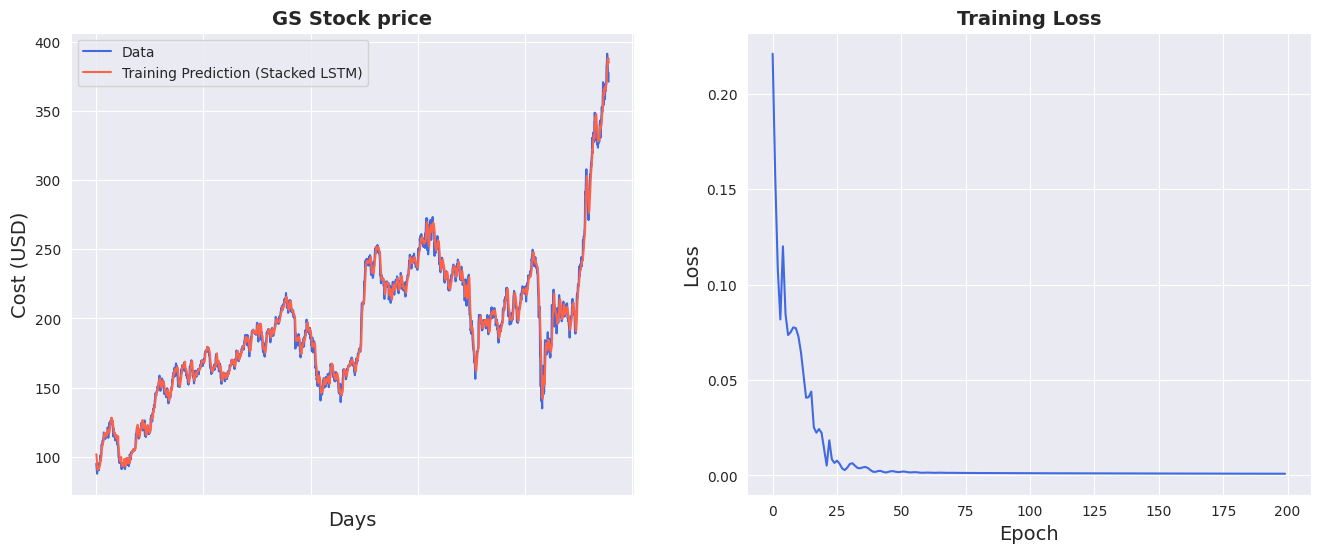

In [ ]:
plot_training_results(s_predict, original, s_train_losses, 'Stacked LSTM')

In [ ]:
slstm_test_pred, slstm_result=evaluation(slstm,x_test,y_test,y_train,slstm_train_pred,device=device)

Train Score: 5.00 RMSE
Test Score: 10.90 RMSE


In [ ]:
#Benchmark
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Reshape data for XGBoost (flatten the time series data)
X_train_flat = x_train.reshape(x_train.shape[0], -1)
X_test_flat = x_test.reshape(x_test.shape[0], -1)

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train_flat, y_train)
result = xgb_model.predict(X_test_flat)
# Predict and evaluate

# Create a dummy array with the same shape as your input features
dummy_array = np.zeros((len(result), X_train_flat.shape[1]))

# Replace the column corresponding to the predicted feature with your predictions
dummy_array[:, -1] = result

# Now apply inverse_transform
xgb_predictions_original_scale = scaler.inverse_transform(dummy_array)[:, -1]


# Create a dummy array with the same shape as your output
dummy_array = np.zeros((len(y_test), y_test.shape[1]))
dummy_array[:, -1] = y_test.flatten()
y_test_original = scaler.inverse_transform(dummy_array)[:, -1]
# Calculate RMSE in the original scale
xgb_rmse_original_scale = np.sqrt(mean_squared_error(y_test_original, xgb_predictions_original_scale))

print(f'XGBoost RMSE on Original Price Scale: {xgb_rmse_original_scale}')


XGBoost RMSE on Original Price Scale: 18.074317236078542


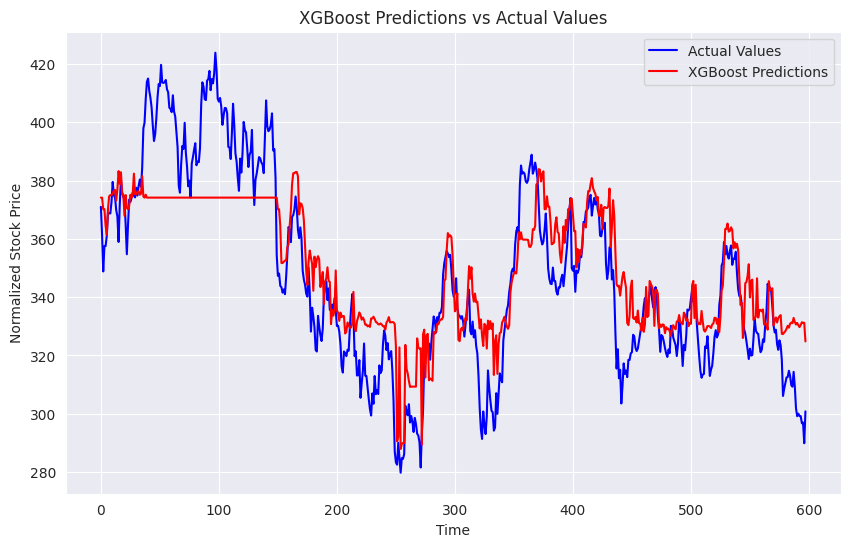

In [ ]:
import matplotlib.pyplot as plt

#plot prediction
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual Values', color='blue')
plt.plot(xgb_predictions_original_scale, label='XGBoost Predictions', color='red')
plt.title('XGBoost Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.svm import SVR

##SVR not use as a benchmark since the inverted RMSE are higher than XGBOOST

# Initialize and train the SVR model
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train_flat, y_train)

# Predict and evaluate
svm_predictions = svm_model.predict(X_test_flat)
svm_rmse = np.sqrt(mean_squared_error(y_test, svm_predictions))
print(f'SVM RMSE: {svm_rmse}')

SVM RMSE: 0.24654940497282476


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#Some analysis at current stage
Higher hidden dimension -> better result. Higher lookback -> better result.Best learning rate -> 0.01 (need further testing)
.Incorporate hyperopt to finish the model

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

def plot_predictions(y_train_pred,y_test_pred, model_name):
  y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
  # shift train predictions for plotting
  trainPredictPlot = np.empty_like(price)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

  # shift test predictions for plotting
  testPredictPlot = np.empty_like(price)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

  original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))
  predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
  predictions = np.append(predictions, original, axis=1)
  result = pd.DataFrame(predictions)

  fig = go.Figure()
  fig.add_trace(go.Scatter(go.Scatter(x=data['Date'], y=result[0],
                    mode='lines',
                    name='Train prediction')))
  fig.add_trace(go.Scatter(x=data['Date'], y=result[1],
                    mode='lines',
                    name='Test prediction'))
  fig.add_trace(go.Scatter(go.Scatter(x=data['Date'], y=result[2],
                    mode='lines',
                    name='Actual Value')))
  fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

  )

  annotations = []
  annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results ('+ model_name + ')',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
  fig.update_layout(annotations=annotations)

  fig.show()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

def plot_predictions(y_train_pred,y_test_pred, model_name, xg):
  y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
  # shift train predictions for plotting
  trainPredictPlot = np.empty_like(price)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

  # shift test predictions for plotting
  testPredictPlot = np.empty_like(price)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

  # shift xgBoost predictions for plotting
  xgPredictPlot = np.empty_like(price)
  xgPredictPlot[:, :] = np.nan
  xg = xg.reshape(-1, 1)
  xgPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = xg

  original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))
  predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
  predictions = np.append(predictions, xgPredictPlot, axis=1)
  predictions = np.append(predictions, original, axis=1)
  result = pd.DataFrame(predictions)

  fig = go.Figure()
  fig.add_trace(go.Scatter(go.Scatter(x=data['Date'], y=result[0],
                    mode='lines',
                    name='Train prediction')))
  fig.add_trace(go.Scatter(x=data['Date'], y=result[1],
                    mode='lines',
                    name='Test prediction'))
  fig.add_trace(go.Scatter(go.Scatter(x=data['Date'], y=result[2],
                    mode='lines',
                    name='XG Value')))
  fig.add_trace(go.Scatter(go.Scatter(x=data['Date'], y=result[3],
                    mode='lines',
                    name='Actual Value')))

  fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

  )

  annotations = []
  annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results ('+ model_name + ')',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
  fig.update_layout(annotations=annotations)

  fig.show()


In [ ]:
plot_predictions(slstm_train_pred,slstm_test_pred,'StackedLSTM',xgb_predictions_original_scale)